In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from scipy import stats as st
pd.options.mode.chained_assignment=None

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.\
Шаги для выбора локации обычно такие:\
В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;\
Строят модель для предсказания объёма запасов в новых скважинах;\
Выбирают скважины с самыми высокими оценками значений;\
Определяют регион с максимальной суммарной прибылью отобранных скважин.\
Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

### Загрузим и подготовим данные.

In [2]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
df1['id'].value_counts()

Tdehs    2
bsk9y    2
74z30    2
HZww2    2
A5aEY    2
        ..
mKosU    1
7lUEF    1
1DxK8    1
66hEY    1
Y6HKm    1
Name: id, Length: 99990, dtype: int64

In [4]:
df1[df1['id']=='bsk9y']

,id,f0,f1,f2,product
89582,bsk9y,0.398908,-0.400253,10.122376,163.433078
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


In [5]:
df1.drop_duplicates(subset='id', inplace=True)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 5 columns):
id         99990 non-null object
f0         99990 non-null float64
f1         99990 non-null float64
f2         99990 non-null float64
product    99990 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [7]:
df1.describe()

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500454,0.250141,2.502629,92.499684
std,0.871844,0.504430,3.248149,44.288304
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072572,-0.200877,0.287784,56.497069
50%,0.502405,0.250252,2.515969,91.847928
75%,1.073626,0.700640,4.715035,128.563699
max,2.362331,1.343769,16.003790,185.364347


In [8]:
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [9]:
df2.drop_duplicates(subset='id', inplace=True)

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
id         99996 non-null object
f0         99996 non-null float64
f1         99996 non-null float64
f2         99996 non-null float64
product    99996 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [11]:
df2.describe()

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141209,-4.796608,2.494501,68.823916
std,8.965815,5.119906,1.703579,45.944663
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011475,57.085625
75%,8.620964,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [12]:
df3 = pd.read_csv('/datasets/geo_data_2.csv')
df3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [13]:
df3.drop_duplicates(subset='id', inplace=True)

In [14]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 5 columns):
id         99996 non-null object
f0         99996 non-null float64
f1         99996 non-null float64
f2         99996 non-null float64
product    99996 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


In [15]:
df3.describe()

,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002002,-0.002159,2.495084,94.998342
std,1.732052,1.730397,3.473482,44.749573
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162328,-1.174841,0.130269,59.450028
50%,0.009424,-0.009661,2.484236,94.925026
75%,1.158477,1.163523,4.858720,130.586815
max,7.238262,7.844801,16.739402,190.029838


In [16]:
df3['id'].value_counts()

2qyKg    1
GU0Ha    1
PvZK9    1
c6j8i    1
v4ixN    1
        ..
81dCY    1
AEc8n    1
FPsCN    1
KhQVx    1
BSP5F    1
Name: id, Length: 99996, dtype: int64

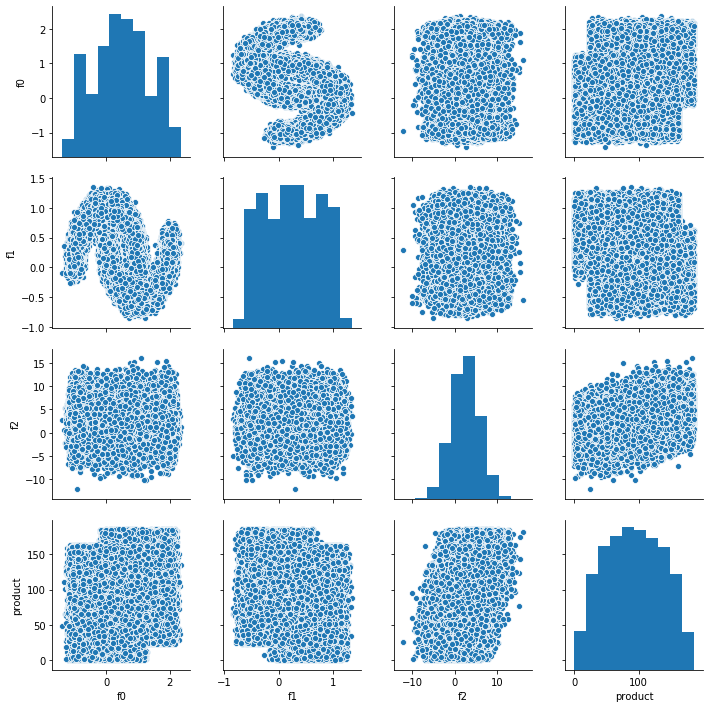

In [17]:
sns.pairplot(df1[['f0', 'f1', 'f2', 'product']])

### Обучим и проверим модель для каждого региона:

In [18]:
data = [df1, df2, df3]
len(data)

3

In [19]:
features = [[],[],[]]
target = [[],[],[]]
features_train, features_valid, target_train, target_valid = [[],[],[]], [[],[],[]], [[],[],[]], [[],[],[]]
model = [[],[],[]]
predicted = [[],[],[]]
pred_true = [[],[],[]]
#Разобъем данные на обучающую и валидационную выборки в соотношении 75:25.
features, target, features_train, features_valid, target_train, target_valid, model, predicted, pred_true, rmse, mean = [ [[],[],[]] for i in range(11) ]
for i in range(len(data)):
    features[i] = data[i].drop(['id', 'product'], axis=1)
    target[i] = data[i]['product']
    features_train[i], features_valid[i], target_train[i], target_valid[i] = train_test_split(
    features[i], target[i], test_size=0.25, random_state=12345)
    model[i] = LinearRegression()
    #Обучим модель и сделаем предсказания на валидационной выборке.
    model[i].fit(features_train[i], target_train[i])
    #Сохраним предсказания и правильные ответы на валидационной выборке
    predicted[i] = model[i].predict(features_valid[i])
    pred_true[i] = pd.concat([pd.Series(predicted[i]),  pd.Series(target_valid[i])], axis=1, ignore_index=True, join='inner', names=['prediction', 'true_value'])
    rmse[i] = (mean_squared_error(target_valid[i], predicted[i]))**0.5
    mean[i] = predicted[i].mean()
    #Напечатаем на экране метрики R2 и MAE по каждому региону:
    print("MAE на обучающей выборке для региона {:>10}: ".format(i+1), mean_absolute_error(target_train[i], model[i].predict(features_train[i]))) 
    print("MAE на валидационной выборке для региона {:>6}: ".format(i+1), mean_absolute_error( target_valid[i], model[i].predict(features_valid[i])))
    print("R2 на обучающей выборке для региона {:>11}: ".format(i+1), r2_score(target_train[i], model[i].predict(features_train[i]))) 
    print("R2 на валидационной выборке для региона {:>7}: ".format(i+1), r2_score(target_valid[i], model[i].predict(features_valid[i]))) 
    print('.......................................................................')
    
    









MAE на обучающей выборке для региона          1:  30.99364389232966
MAE на валидационной выборке для региона      1:  31.141028675220266
R2 на обучающей выборке для региона           1:  0.2767331982099508
R2 на валидационной выборке для региона       1:  0.2723923460817068
.......................................................................
MAE на обучающей выборке для региона          2:  0.7167518849084017
MAE на валидационной выборке для региона      2:  0.7193530096516089
R2 на обучающей выборке для региона           2:  0.9996251255768347
R2 на валидационной выборке для региона       2:  0.9996222988190184
.......................................................................
MAE на обучающей выборке для региона          3:  32.808270307667705
MAE на валидационной выборке для региона      3:  32.83139014902301
R2 на обучающей выборке для региона           3:  0.1998431743734127
R2 на валидационной выборке для региона       3:  0.19556241810202346
.............................

In [20]:
# Напечатаем на экране средний запас предсказанного сырья и RMSE модели
for i in range(len(data)):
    print("  Cредний запас предсказанного сырья для модели региона {}: {:.2f}, RMSE: {:.2f}".format(i+1, mean[i], rmse[i]))

  Cредний запас предсказанного сырья для модели региона 1: 92.79, RMSE: 37.85
  Cредний запас предсказанного сырья для модели региона 2: 69.18, RMSE: 0.89
  Cредний запас предсказанного сырья для модели региона 3: 94.87, RMSE: 40.08


In [21]:
#Случайная модель

In [22]:
med = target_train[i].median()
for i in range(len(data)):
    print("MAE константной модели на валидационной выборке для региона {:>6}: ".format(i+1), mean_absolute_error( target_valid[i], [med for j in target_valid[i]])) 

MAE константной модели на валидационной выборке для региона      1:  37.852559011775185
MAE константной модели на валидационной выборке для региона      2:  44.41380218672756
MAE константной модели на валидационной выборке для региона      3:  37.757163088120144


#### Проанализируем результаты: 1-я и 3-я модели имеют высокое значение ошибки предсказания, и одновременнно предсказывают большие, в сравнении с 2-ой моделью запасы нефти. 2-я модель имеет низкое значение ошибки предсказания.

### Подготовка к расчёту прибыли

#### Cохранение ключевых значений в отдельных переменных.

In [23]:
UNIT_COST = 450 * 1e3 # цена за единицу нефти

In [24]:
INCOME = 200 * UNIT_COST # прибыль от 200  скважин

In [25]:
EXPENSE = 10 * 1e9 # расходы

In [26]:
#прибыль
PROFIT = INCOME - EXPENSE

#### Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

In [27]:
ENOUGH_VOLUME = (EXPENSE/200) / UNIT_COST
ENOUGH_VOLUME

111.11111111111111

#### Выводы по этапу подготовки расчёта прибыли: расчитаны ключевые значения для  нахождения прибыли при выборе и разработке региона.

### Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [28]:
def profit(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (UNIT_COST * selected.sum() - EXPENSE)

### Посчитаем риски и прибыль для каждого региона:

#### Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли и риск убытков:

In [29]:
probabilities, values = [ [[], [], []] for k in range(2)]
for i in range(len(data)):
    count=0
    state = np.random.RandomState(12345)
    target[i] = pd.Series(target_valid[i].reset_index(drop=True))
    probabilities[i] = pd.Series(predicted[i])    
    values[i] = []
    for j in range(1000):
        subsamples_t = target[i].sample(n=500, random_state=state, replace=True)
        subsamples_pr = probabilities[i][subsamples_t.index]
        val = profit(subsamples_t, subsamples_pr, 200)
        values[i].append(val)
        if val<0:
            count+=1
    risk = count/1000*100
    # Найдем среднюю прибыль, 95%-й доверительный интервал
    lower = pd.Series(values[i]).quantile(0.025)
    upper = pd.Series(values[i]).quantile(0.975)
    #risk= (pd.Series(values[i]) < 0).mean()
    print('Риск убытков в регионе {}: {:.1f}'.format(i+1, risk), '%')
    print('Средняя прибыль в регионе  {}: {:.1f}'.format(i+1, pd.Series(values[i]).mean(), '%'))
    print('Нижний квантиль доверительного интервала в регионе {}: {:.1f}'.format(i+1, lower))
    print('Верхний квантиль доверительного интервала в регионе {}: {:.1f}'.format(i+1, upper))
    print('............................................................')

Риск убытков в регионе 1: 7.1 %
Средняя прибыль в регионе  1: 409428038.6
Нижний квантиль доверительного интервала в регионе 1: -131536028.7
Верхний квантиль доверительного интервала в регионе 1: 944395582.8
............................................................
Риск убытков в регионе 2: 0.9 %
Средняя прибыль в регионе  2: 536902587.5
Нижний квантиль доверительного интервала в регионе 2: 114527902.9
Верхний квантиль доверительного интервала в регионе 2: 970787911.0
............................................................
Риск убытков в регионе 3: 10.2 %
Средняя прибыль в регионе  3: 353790362.7
Нижний квантиль доверительного интервала в регионе 3: -159194031.2
Верхний квантиль доверительного интервала в регионе 3: 875652502.9
............................................................


#### Выводы:  предложите регион для разработки скважин и обоснуйте выбор:
Рассчитан 95%-ый доверительный интервал, средняя прибыль и риск убытков для каждого региона. По результатам расчетов во втором регионе мы не понесем убытков с 99% вероятностью, доверительный интевал прибыли полностью расположен в области положительных значений, что не скажешь про 1-й и 3-й регионы (и вероятность убытков больше 2.5%).\
Выбираем для дальнейшей разработки 2-й регион (вероятность убытков меньше 2.5%).

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован